In [29]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline

from keras.models import load_model

import sys
sys.path.append('/home/albert/github/tensorflow/src/')
import evaluation
import triplet

In [30]:
score = np.load('/home/albert/github/tensorflow/pre3/models/neck_cam_inverse_aws/hist.npz')['arr_0'].item()

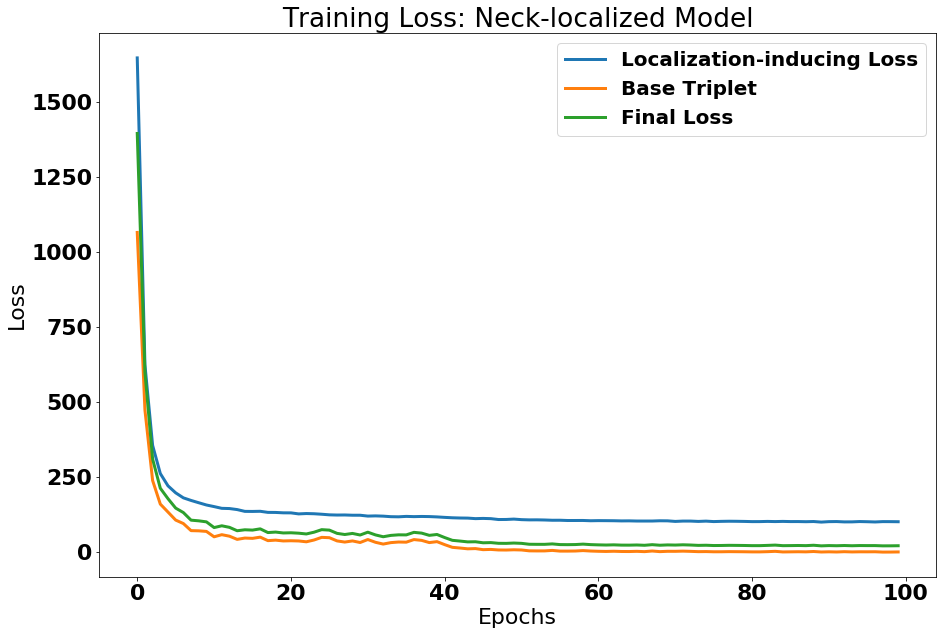

In [33]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

f = plt.figure(figsize=(15,10))
plt.plot(np.arange(100), score['cam_output_loss'], label='Localization-inducing Loss', linewidth=3) 
plt.plot(np.arange(100), score['final_output_loss'], label='Base Triplet', linewidth=3)
plt.plot(np.arange(100), score['loss'], label='Final Loss', linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right',prop={'size': 20})
plt.title('Training Loss: Neck-localized Model')

In [34]:
f.savefig('/home/albert/Desktop/fig/training_loss_neck.png')

In [7]:
dt_score = np.load('/home/albert/github/tensorflow/pre3/models/densenet_triplet/densenet_triplet_score.npz')['arr_0'].item()

In [ ]:
plt.plot(np.arange(150), dt_score)

In [6]:
evaluation.plot_loss('densenet_triplet', ylim_0=0.6, ylim_1=1.0, end_2=False)

IOError: [Errno 2] No such file or directory: '/home/albert/github/tensorflow/models/densenet_triplet/densenet_triplet_score.npz'

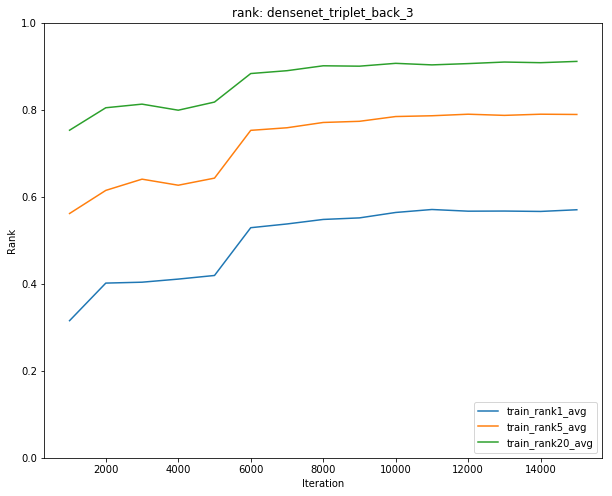

iterations 11000
best_train {1: 0.57096199524940616, 20: 0.90350356294536815, 5: 0.78652019002375295}


In [2]:
evaluation.plot_rank('densenet_triplet_back_3', ylim_0=0.0, ylim_1=1.0, end_2=False)

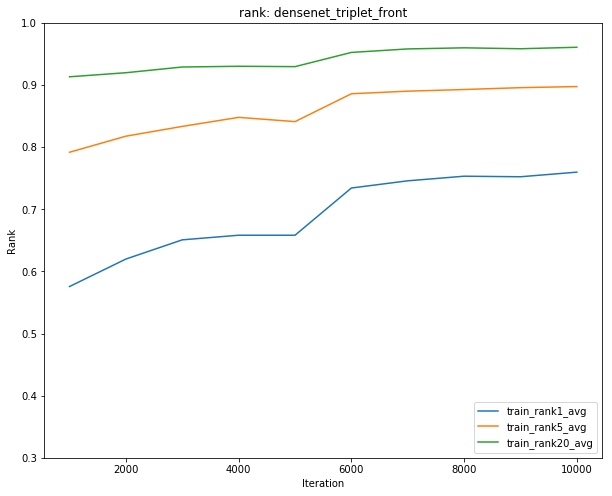

iterations 10000
best_train {1: 0.75979809976247026, 20: 0.96080760095011875, 5: 0.8975653206650831}


In [6]:
evaluation.plot_rank('densenet_triplet_front', ylim_0=0.3, ylim_1=1.0, end_2=False)

In [3]:
score = np.load('/home/albert/github/tensorflow/models/densenet_cam_l1_test/score.npz')['arr_0'].item()

In [5]:
for it in range(1000,11000,1000):
    print it, score[it]['rank']

1000 [0.34768408551068886, 0.5855106888361045, 0.7779097387173397]
2000 [0.39548693586698336, 0.6175771971496437, 0.8078978622327792]
3000 [0.42695961995249404, 0.6701306413301663, 0.8405581947743468]
4000 [0.4100356294536817, 0.6624109263657957, 0.8364014251781473]
5000 [0.46288598574821854, 0.7069477434679335, 0.8657957244655582]
6000 [0.5489904988123515, 0.7871140142517815, 0.9091448931116389]
7000 [0.5973871733966746, 0.8245249406175772, 0.9302256532066508]
8000 [0.6288598574821853, 0.8402612826603325, 0.9421021377672208]
9000 [0.6371733966745843, 0.8420427553444181, 0.940914489311164]
10000 [0.6493467933491687, 0.8429334916864608, 0.9415083135391924]


In [ ]:
trinet = dense.DenseNetImageNet121(input_shape=(256,128,3), weights=None)
import keras.backend as Keras
from keras.layers import Lambda
from keras.losses import categorical_crossentropy
import tensorflow as tf

def cam(im, cam_dim=(16,8)):
    cam_mean = Keras.mean(tf.image.resize_images(im, cam_dim), axis=3)
    cam_min = tf.tile(tf.reshape(Keras.min(cam_mean, axis=(1,2)), (-1, 1, 1)), (1,cam_dim[0],cam_dim[1]))
    cam_mean = cam_mean - cam_min
    cam_max = tf.tile(tf.reshape(Keras.max(cam_mean, axis=(1,2)), (-1, 1, 1)), (1,cam_dim[0],cam_dim[1]))
    cam_norm = tf.div(cam_mean, cam_max)
    return cam_mean

cam_output = Lambda(cam, name='cam_output')(trinet.layers[-6].output)
camnet = Model(inputs=trinet.input, outputs=[trinet.output, cam_output])
camnet.compile(loss=categorical_crossentropy, loss_weights=[1.0, 0.1],
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
camnet.set_weights(np.load('/home/ubuntu/albert/models/densenet_cam/densenet_cam_10000.npy'))
DATA_ROOT = '/home/ubuntu/albert/'
train_dict, train_files = data.get_data('train', DATA_ROOT=DATA_ROOT)
start = time.time()
batch = data.output_batch_generator(train_dict, P=8, preprocess=False,
                                    shape=(256,128), keypoints=None, 
                                    cam_output_dim=(16,8), 
                                    DATA_ROOT=DATA_ROOT).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()
# from scipy.special import expit
cam = camnet.predict(densenet.preprocess_input(batch[0]['input_im'][3].copy()).reshape((1,256,128,3)))[1][0]
plt.subplot(131)
plt.imshow(batch[0]['input_im'][3].astype(np.uint8))
plt.subplot(132)
plt.imshow(cam, cmap=plt.cm.jet)
plt.subplot(133)
plt.imshow(batch[1]['cam_output'][3], cmap=plt.cm.jet)
plt.show()
plt.hist(cam.flatten(), bins=10)
plt.show()
plt.hist(batch[1]['cam_output'][3].flatten(), bins=10)
plt.show()
norm = 2
print np.power(np.sum(np.power(np.abs(batch[1]['cam_output'][3] - cam), norm), axis=(0,1)), 1.0 / norm)
plt.imshow(np.random.rand(16,8), cmap=plt.cm.jet)
plt.show()
norm = 2
print np.power(np.sum(np.power(np.abs(batch[1]['cam_output'][3] - np.random.rand(16,8)), norm), axis=(0,1)), 1.0 / norm)
intermediate = Model(inputs=camnet.input, outputs=camnet.layers[308].output)
camnet.compile(loss=categorical_crossentropy,
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
for l in range(len(camnet.layers)):
    if camnet.layers[l].name.find('average_pooling2d') > -1:
        print l
htmps = intermediate.predict(densenet.preprocess_input(batch[0]['input_im'][3].copy()).reshape((1,256,128,3)))[0]
plt.imshow(np.mean(htmps, axis=2))
plt.show()
for i in range(100):
    plt.imshow(htmps[..., i], cmap=plt.cm.gray)
    plt.show()